# Multi-Layer Perceptron Model Investigation


In [1]:
# Import required modules

import pandas as pd
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Pre-processing

In [2]:
# Read in Data
df = pd.read_csv('data/data.csv', encoding = 'latin1')
cpi = pd.read_csv('data/cpi.csv')
df.head()
cpi.head()

C:\Users\delac\AppData\Local\Temp\ipykernel_16124\949920952.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/data.csv', encoding = 'latin1')


,Quarter,CPI
0,2021Q1,117.9
1,2021Q2,118.8
2,2021Q3,119.7
3,2021Q4,121.3
4,2022Q1,123.9


In [3]:
df = df.drop_duplicates(subset=[col for col in df.columns if col not in ['BookingID', 'BCreatedDateAEST', 'BStatusFinal', 'BTicketID' ]])

In [4]:
# Assign priority: 'completed' gets highest priority (lowest number)

df['status_priority'] = df['BStatusAfterSubmitted'].apply(lambda x: 0 if x == '33. Approved' else 1)

# Define the columns used to detect duplicates (all except 'status' and 'status_priority')
dedup_cols = [col for col in df.columns if col not in ['BStatusAfterSubmitted', 'BStatusFromDateTimeAEST', 'status_priority']]

# Sort so that 'completed' comes last within each group of duplicate rows
df_sorted = df.sort_values(by=dedup_cols + ['status_priority'])

# Drop duplicates based on all columns except status, keeping the preferred row (last)
df_deduped = df_sorted.drop_duplicates(subset=dedup_cols, keep='last')

# Drop the helper column
df_deduped = df_deduped.drop(columns='status_priority')

df = df_deduped
#df_deduped.shape[0]



### Feature Selection

In [5]:
# Price adjustment for inflation
df['BCreatedDateAEST'] = pd.to_datetime(df['BCreatedDateAEST'], dayfirst=True);
df['Quarter'] = df['BCreatedDateAEST'].dt.to_period('Q');
cpi['Quarter'] = pd.to_datetime(cpi['Quarter']).dt.to_period('Q');
base_cpi = cpi['CPI'].iloc[-1]

C:\Users\delac\AppData\Local\Temp\ipykernel_16124\3542310774.py:2: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['BCreatedDateAEST'] = pd.to_datetime(df['BCreatedDateAEST'], dayfirst=True);
C:\Users\delac\AppData\Local\Temp\ipykernel_16124\3542310774.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cpi['Quarter'] = pd.to_datetime(cpi['Quarter']).dt.to_period('Q');


In [6]:
# Create a column for the adjusted price 
df = df.merge(cpi, on='Quarter');
df['Quarter'] = df['BCreatedDateAEST'].dt.quarter;

#Round to two decimal places to remain consistent with the existing data
df['adjusted_price'] = round(df['PriceIncGSTRaw'] * (base_cpi / df['CPI']), 2)

In [7]:
# Display merged dataset
pd.set_option('display.max_columns', None)

df.head()

,FCID,BookingID,BCreatedDateAEST,BStatusAfterSubmitted,BStatusFromDateTimeAEST,BStatusFinal,BTicketID,BTicketType,TaskName,IsCustomService,IsCustomRepair,IsDeleted,PriceIncGSTRaw,VYMM,VMakeModel,VMake,VYear,VMid,VRego,BShopID,BShopPostcode,BShopState,BShopRegionName,BShopRegionClass,Quarter,CPI,adjusted_price
0,1,392968,2021-01-03,33. Approved,2021-01-03 14:14:33,64. Completed,600825,Log,"Logbook Service - 75,000 km / 60 months",0,0,False,858.37,2015 HYUNDAI I30,HYUNDAI I30,HYUNDAI,2015.0,HYU39370,DCZ03G,14351,2019,NSW,Sydney,1.0,1,117.9,1014.90
1,1,393040,2021-01-04,33. Approved,2021-01-04 08:50:45,64. Completed,600971,Tyres,((Tyres)),0,0,False,82.50,2016 KIA SPORTAGE,KIA SPORTAGE,KIA,2016.0,KIA39610,DHJ24P,17969,2232,NSW,Sydney,1.0,1,117.9,97.54
2,1,393045,2021-01-04,33. Approved,2021-01-22 14:30:26,64. Completed,600977,Capped,"Capped Price Service - 90,000 km",0,0,False,931.00,2018 MITSUBISHI TRITON,MITSUBISHI TRITON,MITSUBISHI,2018.0,MIT38449,DVA72S,16569,2606,ACT,Canberra,2.0,1,117.9,1100.78
3,1,393045,2021-01-04,33. Approved,2021-01-22 14:30:26,64. Completed,601272,Repair,Custom Repair,0,1,False,61.29,2018 MITSUBISHI TRITON,MITSUBISHI TRITON,MITSUBISHI,2018.0,MIT38449,DVA72S,16569,2606,ACT,Canberra,2.0,1,117.9,72.47
4,1,393045,2021-01-04,33. Approved,2021-01-22 14:30:26,64. Completed,601273,Repair,Rocker/Valve Cover Gasket Replacement,0,0,False,440.00,2018 MITSUBISHI TRITON,MITSUBISHI TRITON,MITSUBISHI,2018.0,MIT38449,DVA72S,16569,2606,ACT,Canberra,2.0,1,117.9,520.24


In [8]:

columns_to_keep = ['BStatusAfterSubmitted', 'VMake', 'VMakeModel', 'VYear', 'adjusted_price', 'TaskName', 'BShopRegionName', 'VYMM', 'VMid',]
df = df[columns_to_keep]
df['Label'] = df['BStatusAfterSubmitted'].map({'33. Approved': 1, '16. Requires Changes': 0, '29. Rejected': 0})
df = df.drop('BStatusAfterSubmitted', axis=1)

df.head()

,VMake,VMakeModel,VYear,adjusted_price,TaskName,BShopRegionName,VYMM,VMid,Label
0,HYUNDAI,HYUNDAI I30,2015.0,1014.90,"Logbook Service - 75,000 km / 60 months",Sydney,2015 HYUNDAI I30,HYU39370,1
1,KIA,KIA SPORTAGE,2016.0,97.54,((Tyres)),Sydney,2016 KIA SPORTAGE,KIA39610,1
2,MITSUBISHI,MITSUBISHI TRITON,2018.0,1100.78,"Capped Price Service - 90,000 km",Canberra,2018 MITSUBISHI TRITON,MIT38449,1
3,MITSUBISHI,MITSUBISHI TRITON,2018.0,72.47,Custom Repair,Canberra,2018 MITSUBISHI TRITON,MIT38449,1
4,MITSUBISHI,MITSUBISHI TRITON,2018.0,520.24,Rocker/Valve Cover Gasket Replacement,Canberra,2018 MITSUBISHI TRITON,MIT38449,1


### Data Splitting


In [9]:

# Separate features and target
X = df.drop('Label', axis=1)
y = df['Label']

train_X, test_X, train_Y, test_Y = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(train_X.columns)
print(test_X.columns)

Index(['VMake', 'VMakeModel', 'VYear', 'adjusted_price', 'TaskName',
       'BShopRegionName', 'VYMM', 'VMid'],
      dtype='object')
Index(['VMake', 'VMakeModel', 'VYear', 'adjusted_price', 'TaskName',
       'BShopRegionName', 'VYMM', 'VMid'],
      dtype='object')


In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Select the categorical columns to encode
categorical_cols = ['VMake', 'VYear', 'VMakeModel', 'TaskName', 'BShopRegionName', 'VYMM', 'VMid']

# Create the ColumnTransformer with OneHotEncoder for selected categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # keep the remaining columns as-is
)

# Fit on training data only
Encoded_train_X = preprocessor.fit_transform(train_X)

# Transform test data (and/or validation data)
Encoded_test_X = preprocessor.transform(test_X)

# Convert to DataFrame for column visibility (optional)
# Get feature names (works with scikit-learn 1.0+)
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(encoded_feature_names) + [col for col in train_X.columns if col not in categorical_cols]

Encoded_train_X = pd.DataFrame(Encoded_train_X.toarray(), columns=all_feature_names)
Encoded_test_X = pd.DataFrame(Encoded_test_X.toarray(), columns=all_feature_names)

print("After One-Hot Encoding (train_X columns):", Encoded_train_X.columns)

MemoryError: Unable to allocate 62.6 GiB for an array with shape (651617, 12897) and data type float64

In [ ]:
#Binary Encodes Task name, VYMM, VMake and Shop region name
binary_encoder = ce.OneHotEncoder(cols=['VMake', 'VYear', 'VMakeModel', 'TaskName', 'BShopRegionName', 'VYMM', 'VMid',])
Encoded_train_X = binary_encoder.fit_transform(train_X)
Encoded_test_X = binary_encoder.transform(test_X)
print("After Binary Encoding (train_X columns):", Encoded_train_X.columns)

#Encoded_train_X.head()
#Encoded_val_X.head()
#Encoded_test_X.head()

#When data is split, ensure that fit is ONLY applied to the train dataset, then proceed to transform both train and test.

MemoryError: Unable to allocate 10.4 GiB for an array with shape (2136, 651617) and data type int64

In [ ]:
X_train_enc = Encoded_train_X.copy()
X_test_enc = Encoded_test_X.copy()

for col in X_train_enc.select_dtypes(['category']).columns:
    X_test_enc[col] = X_test_enc[col].astype('category')
    X_test_enc[col] = X_test_enc[col].cat.set_categories(X_train_enc[col].cat.categories)
    X_train_enc[col] = X_train_enc[col].cat.codes
    X_test_enc[col] = X_test_enc[col].cat.codes

### Scaling

In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Batch-wise partial fitting
batch_size = 1000
num_rows = Encoded_train_X.shape[0]

for i in range(0, num_rows, batch_size):
    batch = Encoded_train_X[i:i+batch_size]
    scaler.partial_fit(batch)

train_X_scaled = np.empty_like(Encoded_train_X)

for i in range(0, num_rows, batch_size):
    batch = Encoded_train_X[i:i+batch_size]
    train_X_scaled[i:i+batch_size] = scaler.transform(batch)


## Training the Model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from scipy.stats import uniform, randint
from time import time
'''
# Define the model
mlp = MLPClassifier(max_iter=300, random_state=42)

# Define hyperparameter search space
params = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (50, 100), (100, 100)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': uniform(0.0001, 0.01),
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': uniform(0.0001, 0.01),
    'batch_size': randint(16, 128),
}

# Time the random search
search_start = time()

random_search = RandomizedSearchCV(
    mlp,
    param_distributions=params,
    n_iter=3,
    scoring='accuracy',
    cv=2,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

# Fit the random search
random_search.fit(train_X_scaled, train_Y)

search_end = time()
print(f"\n Randomized Search took: {search_end - search_start:.2f} seconds")'''

# Define model with your specific parameters
mlp = MLPClassifier(
    activation='relu',
    alpha=np.float64(0.006608884729488529),
    batch_size=68,
    hidden_layer_sizes=(100,),
    learning_rate='adaptive',
    learning_rate_init=np.float64(0.008424426408004218),
    solver='sgd',
    max_iter=300,
    random_state=42,
    verbose=True
)

# Train the model
train_start = time()
mlp.fit(train_X_scaled, train_Y)
train_end = time()

print(f"\nTraining completed in {train_end - train_start:.2f} seconds.")

Iteration 1, loss = 0.57382066
Iteration 2, loss = 0.56317129
Iteration 3, loss = 0.55813528
Iteration 4, loss = 0.55495906
Iteration 5, loss = 0.55292758
Iteration 6, loss = 0.55143297
Iteration 7, loss = 0.55031125
Iteration 8, loss = 0.54942994
Iteration 9, loss = 0.54877753
Iteration 10, loss = 0.54793015
Iteration 11, loss = 0.54725201
Iteration 12, loss = 0.54645331
Iteration 13, loss = 0.54580478
Iteration 14, loss = 0.54531104
Iteration 15, loss = 0.54487938
Iteration 16, loss = 0.54457954
Iteration 17, loss = 0.54436176
Iteration 18, loss = 0.54405164
Iteration 19, loss = 0.54375037
Iteration 20, loss = 0.54362859
Iteration 21, loss = 0.54347449
Iteration 22, loss = 0.54325788
Iteration 23, loss = 0.54318464
Iteration 24, loss = 0.54295160
Iteration 25, loss = 0.54281308
Iteration 26, loss = 0.54279783
Iteration 27, loss = 0.54275772
Iteration 28, loss = 0.54235542
Iteration 29, loss = 0.54237198
Iteration 30, loss = 0.54225685
Iteration 31, loss = 0.54214597
Iteration 32, los

## Evaluation

In [ ]:
# 8. Evaluate
y_pred = best_mlp.predict(test_X_scaled)
y_proba = best_mlp.predict_proba(test_X_scaled)[:, 1]  # For ROC/AUC

print("Train score:", best_mlp.score(train_X_scaled, train_Y))
print("Test score:", best_mlp.score(test_X_scaled, test_Y)) 


Train score: 0.6338625727157416
Test score: 0.6238929344617201


In [ ]:
print(test_Y.shape)
print(y_pred.shape)


(15243,)
(15243,)


In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , confusion_matrix, roc_auc_score
print("Accuracy:", accuracy_score(test_Y, y_pred))
print("Precision:", precision_score(test_Y, y_pred))
print("Recall:", recall_score(test_Y, y_pred))
print("F1 Score:", f1_score(test_Y, y_pred))
print("ROC AUC:", roc_auc_score(test_Y, y_proba))
print("Confusion Matrix:\n", confusion_matrix(test_Y, y_pred))

Accuracy: 0.6238929344617201
Precision: 0.5376162299239222
Recall: 0.318
F1 Score: 0.3996229971724788
ROC AUC: 0.6422786793609578
Confusion Matrix:
 [[7602 1641]
 [4092 1908]]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

# Confidence score at the moment is its confidence in their prediction being correct
# Currently at 1 because its overfitting and is hence over confident 
def eval_classification_performance(model, train_X, y_train, eval_X, y_eval):
    """
    Evaluates a scikit-learn classification model on training and an evaluation dataset,
    displays confusion matrices, prints a classification report, and shows average confidence.

    Args:
        model: Trained scikit-learn classification model.
        train_X: Training features (pandas DataFrame).
        y_train: Training target (pandas Series).
        eval_X: Evaluation features (pandas DataFrame - typically validation or test).
        y_eval: Evaluation target (pandas Series - typically validation or test).
    """
    print("Evaluating model performance...")

    train_pred_labels = model.predict(train_X)

    eval_pred_labels = model.predict(eval_X)

    eval_pred_proba = model.predict_proba(eval_X)

    eval_confidence_in_prediction = np.max(eval_pred_proba, axis=1)

    train_acc = accuracy_score(y_train, train_pred_labels)
    eval_acc = accuracy_score(y_eval, eval_pred_labels) 

    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Evaluation Accuracy: {eval_acc:.4f}") 

    print(f"Average Confidence in Predicted Class on Evaluation Set: {np.mean(eval_confidence_in_prediction):.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(15, 6)) 

    ConfusionMatrixDisplay.from_predictions(y_train, train_pred_labels, normalize='true', ax=axes[0])
    axes[0].set_title(f"Training Set Performance: Accuracy={train_acc:.2f}")
    axes[0].set_xlabel("Predicted label")
    axes[0].set_ylabel("True label")

    ConfusionMatrixDisplay.from_predictions(y_eval, eval_pred_labels, normalize='true', ax=axes[1])
    axes[1].set_title(f"Evaluation Set Performance: Accuracy={eval_acc:.2f}") 
    axes[1].set_xlabel("Predicted label")
    axes[1].set_ylabel("True label")


    plt.tight_layout()
    plt.show()

    print("\nEvaluation Set Classification Report:") 
    
    print(classification_report(y_eval, eval_pred_labels))



Evaluating model performance...
Training Accuracy: 0.6339
Evaluation Accuracy: 0.6239
Average Confidence in Predicted Class on Evaluation Set: 0.6199


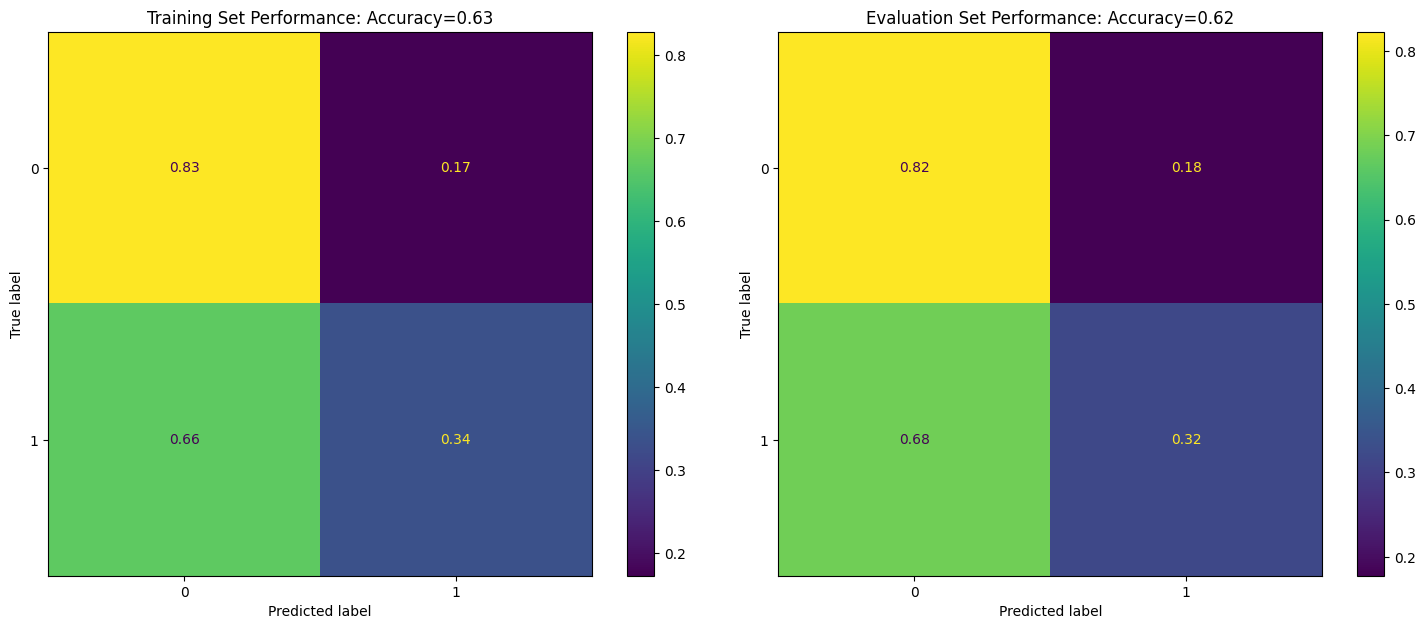


Evaluation Set Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.82      0.73      9243
           1       0.54      0.32      0.40      6000

    accuracy                           0.62     15243
   macro avg       0.59      0.57      0.56     15243
weighted avg       0.61      0.62      0.60     15243



In [ ]:
eval_classification_performance(best_mlp, train_X_scaled, train_Y, test_X_scaled, test_Y)

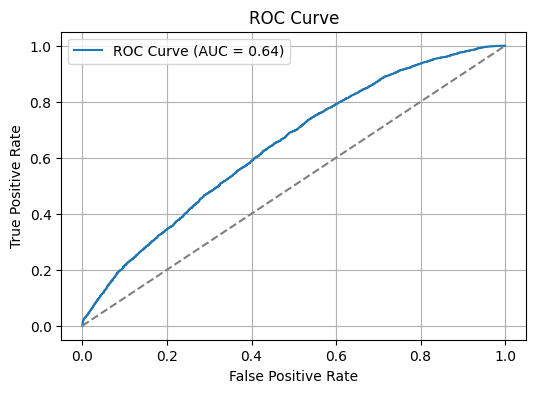

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(test_Y, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(test_Y, y_proba):.2f})")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

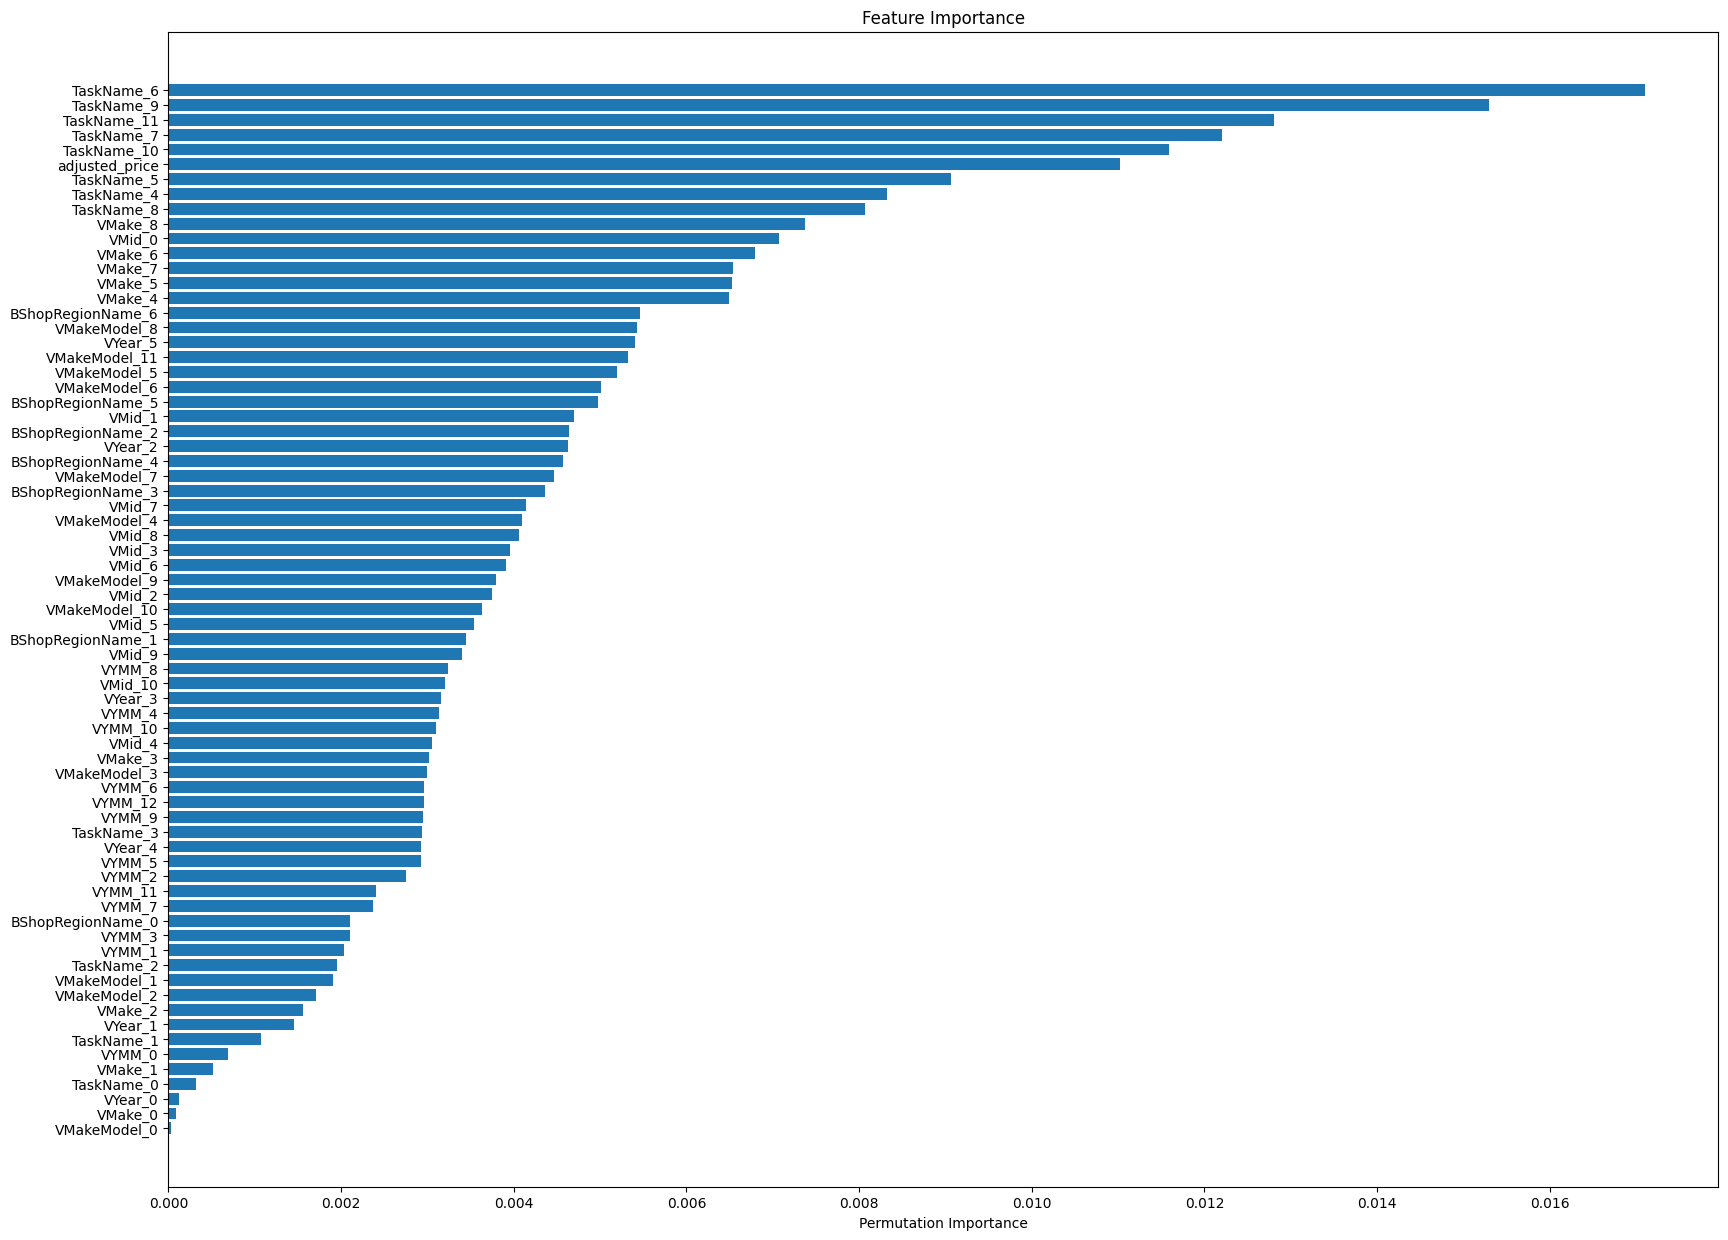

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_mlp, train_X_scaled, train_Y, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))

plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(Encoded_train_X.columns)[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.show()

In [ ]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=train_X_scaled,
    feature_names=Encoded_train_X.columns,
    class_names=np.unique(train_Y),
    mode='classification'
)

i = 0  # index of instance to explain
exp = explainer.explain_instance(train_X_scaled[i], best_mlp.predict_proba)


MemoryError: Unable to allocate 4.97 MiB for an array with shape (651617,) and data type int64

[('VMake_0 <= -0.03', -0.35069629350222065), ('VYMM_0 <= -0.09', -0.25436282688569245), ('adjusted_price > 0.15', -0.1534753738308017), ('VMakeModel_1 <= -0.10', 0.0730569284014029), ('TaskName_7 <= -0.74', -0.0703826102441674), ('VYMM_2 <= -0.36', -0.06618151923244339), ('VMake_4 <= -0.37', 0.06305412731089415), ('VMake_3 <= -0.18', -0.058417043184514836), ('TaskName_0 <= -0.04', 0.05332665874486834), ('VYear_0 <= -0.03', -0.045531854813953034)]


C:\Users\delac\AppData\Local\Temp\ipykernel_13728\482656293.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


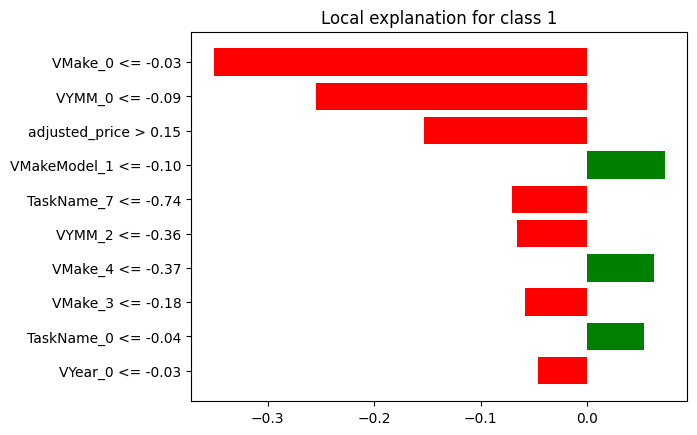

In [ ]:
print(exp.as_list())  # Outputs explanation as a list of (feature, weight) pairs
fig = exp.as_pyplot_figure()
fig.show()